# Duckietown NCTU - Tutorial 2: Drive without Joystick

By Brian Chuang and Nick Wang

## Import Packages

In [1]:
import numpy as np
import scipy as sp
import cv2
import time

from matplotlib import pyplot as plt
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels

## ROS Setup

In [2]:
import sys
# rospy
sys.path.insert(0, '/opt/ros/indigo/lib/python2.7/dist-packages')
# rospkg
sys.path.insert(0, '/usr/lib/python2.7/dist-packages/')

# duckietown_msgs
duckietown_root = '../../'  # this file should be run from {duckietown_root}/turorials/python (otherwise change this line)
sys.path.insert(0, duckietown_root + 'catkin_ws/devel/lib/python2.7/dist-packages')

import rospy
from duckietown_msgs.msg import  Twist2DStamped


### you need a roscore or roslaunch first

In [3]:
#%%bash --bg
#roscore

In [4]:
rospy.init_node("joystick_jupyter",anonymous=False)
#please replace "wama" with your duckiebot name
pub_car_cmd = rospy.Publisher("/wama/joystick_jupyter/car_cmd",Twist2DStamped,queue_size=1)
#rospy.spin()

In [9]:
def car_command(v, omega, duration):
# Send stop command
    car_control_msg = Twist2DStamped()
    car_control_msg.v = v 
    car_control_msg.omega = omega 
    pub_car_cmd.publish(car_control_msg)
    rospy.sleep(duration)
    #rospy.loginfo("Shutdown")
    car_control_msg.v = 0.0 
    car_control_msg.omega = 0.0 
    pub_car_cmd.publish(car_control_msg)   


In [10]:
%%bash
rostopic list

/rosout
/rosout_agg
/wama/inverse_kinematics_node/wheels_cmd
/wama/joystick_jupyter/car_cmd
/wama/wheels_driver_node/emergency_stop
/wama/wheels_driver_node/wheels_cmd_executed


## EXERCISE: Forward (F), Turn Left (L), or Turn Right (R)

Send commands and calibrate your duckiebot

### Ex1: Forward 0.5 Tile Width

In [22]:
car_command(0.2, 0, 2)

### EX2: Turn 45 or 90 Degrees

In [25]:
car_command(0.1, 2, 2)

## Let's Learn Some AI (Graph + A*)

See https://github.com/aimacode/aima-python.git for detail (Python 3)

See https://github.com/hobson/aima.git for detail (Python 2)

In [26]:
# package from AIMA
import sys
import os
sys.path.append("02-tutorial")
import utils
from search import *

In [27]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

In [28]:
romania_locations = romania_map.locations
print(romania_locations)

{'Drobeta': (165, 299), 'Bucharest': (400, 327), 'Vaslui': (509, 444), 'Urziceni': (456, 350), 'Giurgiu': (375, 270), 'Zerind': (108, 531), 'Lugoj': (165, 379), 'Oradea': (131, 571), 'Timisoara': (94, 410), 'Pitesti': (320, 368), 'Hirsova': (534, 350), 'Craiova': (253, 288), 'Neamt': (406, 537), 'Fagaras': (305, 449), 'Sibiu': (207, 457), 'Mehadia': (168, 339), 'Arad': (91, 492), 'Iasi': (473, 506), 'Rimnicu': (233, 410), 'Eforie': (562, 293)}


### Visualize Graph

In [29]:
# Visualize Graph
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

In [30]:
# initialise a graph
G = nx.Graph()

# use this while labeling nodes in the map
node_labels = dict()
# use this to modify colors of nodes while exploring the graph.
# This is the only dict we send to `show_map(node_colors)` while drawing the map
node_colors = dict()

for n, p in romania_locations.items():
    # add nodes from romania_locations
    G.add_node(n)
    # add nodes to node_labels
    node_labels[n] = n
    # node_colors to color nodes while exploring romania map
    node_colors[n] = "white"

# we'll save the initial node colors to a dict to use later
initial_node_colors = dict(node_colors)
    
# positions for node labels
node_label_pos = {k:[v[0],v[1]-10] for k,v in romania_locations.items()}

# use thi whiel labeling edges
edge_labels = dict()

# add edges between cities in romania map - UndirectedGraph defined in search.py
for node in romania_map.nodes():
    connections = romania_map.get(node)
    for connection in connections.keys():
        distance = connections[connection]
        # add edges to the graph
        G.add_edge(node, connection)
        # add distances to edge_labels
        edge_labels[(node, connection)] = distance

In [31]:
def show_map(node_colors):
    # set the size of the plot
    plt.figure(figsize=(18,13))
    # draw the graph (both nodes and edges) with locations from romania_locations
    nx.draw(G, pos = romania_locations, node_color = [node_colors[node] for node in G.nodes()])

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos = node_label_pos, labels = node_labels, font_size = 14)
    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos = romania_locations, edge_labels=edge_labels, font_size = 14)
    
    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="gray")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle),
               ('Un-explored', 'Frontier', 'Currently exploring', 'Explored'),
               numpoints=1,prop={'size':16}, loc=(.8,.75))
    
    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()

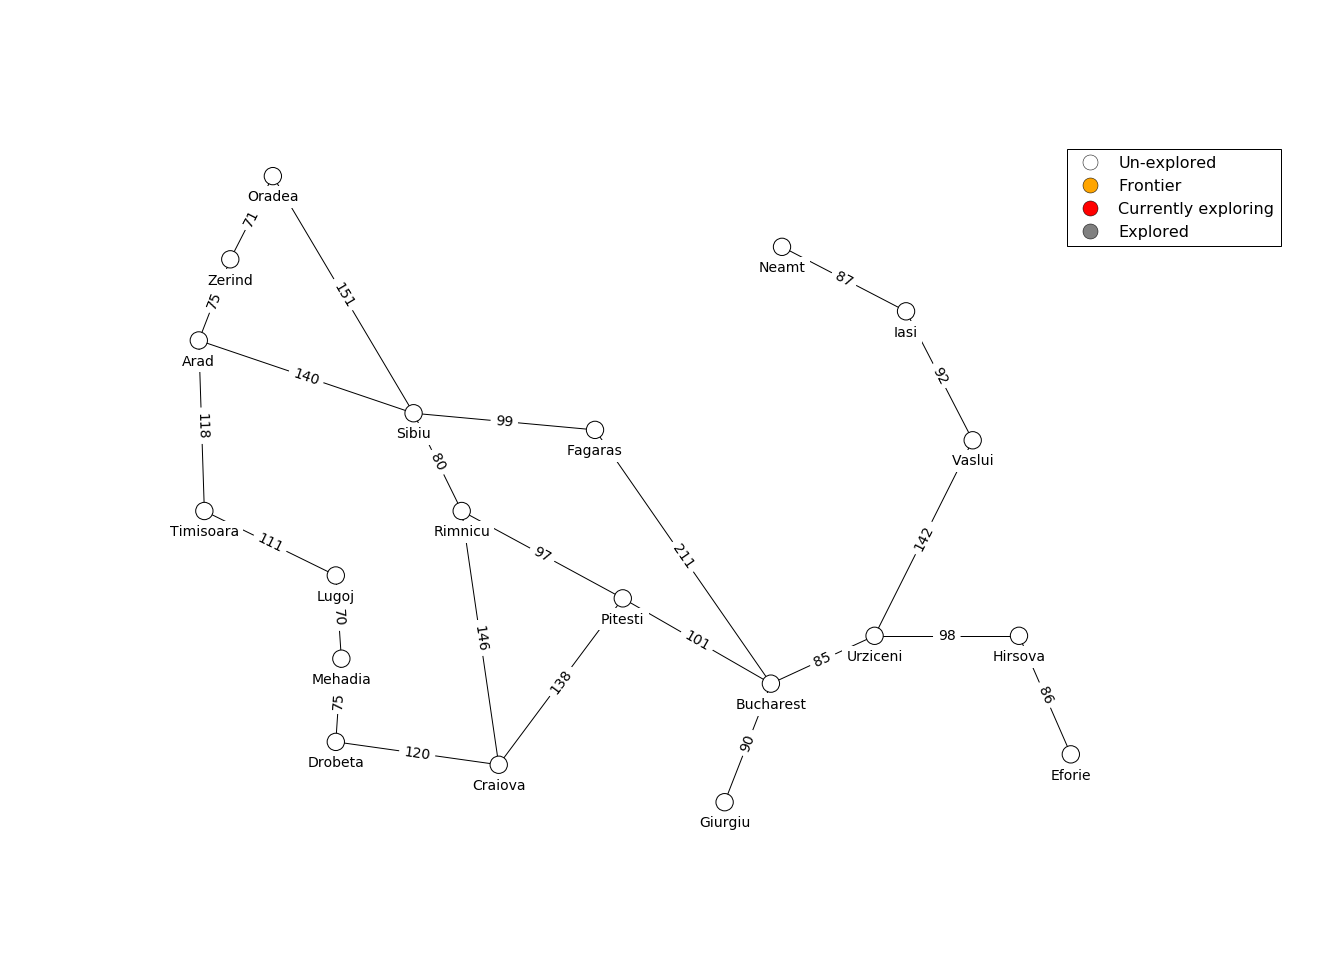

In [32]:
show_map(node_colors)

In [33]:
def final_path_colors(problem, solution):
    "returns a node_colors dict of the final path provided the problem and solution"
    
    # get initial node colors
    final_colors = dict(initial_node_colors)
    # color all the nodes in solution and starting node to green
    final_colors[problem.initial] = "green"
    for node in solution:
        final_colors[node] = "green"  
    return final_colors


def display_visual(user_input, algorithm=None, problem=None):
    if user_input == False:
        def slider_callback(iteration):
            # don't show graph for the first time running the cell calling this function
            try:
                show_map(all_node_colors[iteration])
            except:
                pass
        def visualize_callback(Visualize):
            if Visualize is True:
                button.value = False
                
                global all_node_colors
                
                iterations, all_node_colors, node = algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(problem, solution))
                
                slider.max = len(all_node_colors) - 1
                
                for i in range(slider.max + 1):
                    slider.value = i
    #                 time.sleep(.5)
        
        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration = slider)
        display(slider_visual)

        button = widgets.ToggleButton(value = False)
        button_visual = widgets.interactive(visualize_callback, Visualize = button)
        display(button_visual)
    
    if user_input == True:
        node_colors = dict(initial_node_colors)
        if algorithm == None:
            algorithms = {"Breadth First Tree Search": breadth_first_tree_search, "Breadth First Search": breadth_first_search, "Uniform Cost Search": uniform_cost_search, "A-star Search": astar_search}
            algo_dropdown = widgets.Dropdown(description = "Search algorithm: ", options = sorted(list(algorithms.keys())), value = "Breadth First Tree Search")
            display(algo_dropdown)
        
        def slider_callback(iteration):
            # don't show graph for the first time running the cell calling this function
            try:
                show_map(all_node_colors[iteration])
            except:
                pass
            
        def visualize_callback(Visualize):
            if Visualize is True:
                button.value = False
                
                problem = GraphProblem(start_dropdown.value, end_dropdown.value, romania_map)
                global all_node_colors
                
                if algorithm == None:
                    user_algorithm = algorithms[algo_dropdown.value]
                
#                 print(user_algorithm)
#                 print(problem)
                
                iterations, all_node_colors, node = user_algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(problem, solution))

                slider.max = len(all_node_colors) - 1
                
                for i in range(slider.max + 1):
                    slider.value = i
#                     time.sleep(.5)
                         
        start_dropdown = widgets.Dropdown(description = "Start city: ", options = sorted(list(node_colors.keys())), value = "Arad")
        display(start_dropdown)

        end_dropdown = widgets.Dropdown(description = "Goal city: ", options = sorted(list(node_colors.keys())), value = "Fagaras")
        display(end_dropdown)
        
        button = widgets.ToggleButton(value = False)
        button_visual = widgets.interactive(visualize_callback, Visualize = button)
        display(button_visual)
        
        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration = slider)
        display(slider_visual)
        

### Breath First Search

In [34]:
def tree_search(problem, frontier):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    frontier.append(Node(problem.initial))
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def breadth_first_tree_search(problem):
    "Search the shallowest nodes in the search tree first."
    iterations, all_node_colors, node = tree_search(problem, FIFOQueue())
    return(iterations, all_node_colors, node)

Node Visualization
* Un-explored nodes - <font color='black'>white</font>
* Frontier nodes - <font color='orange'>orange</font>
* Currently exploring node - <font color='red'>red</font>
* Already explored nodes - <font color='gray'>gray</font>

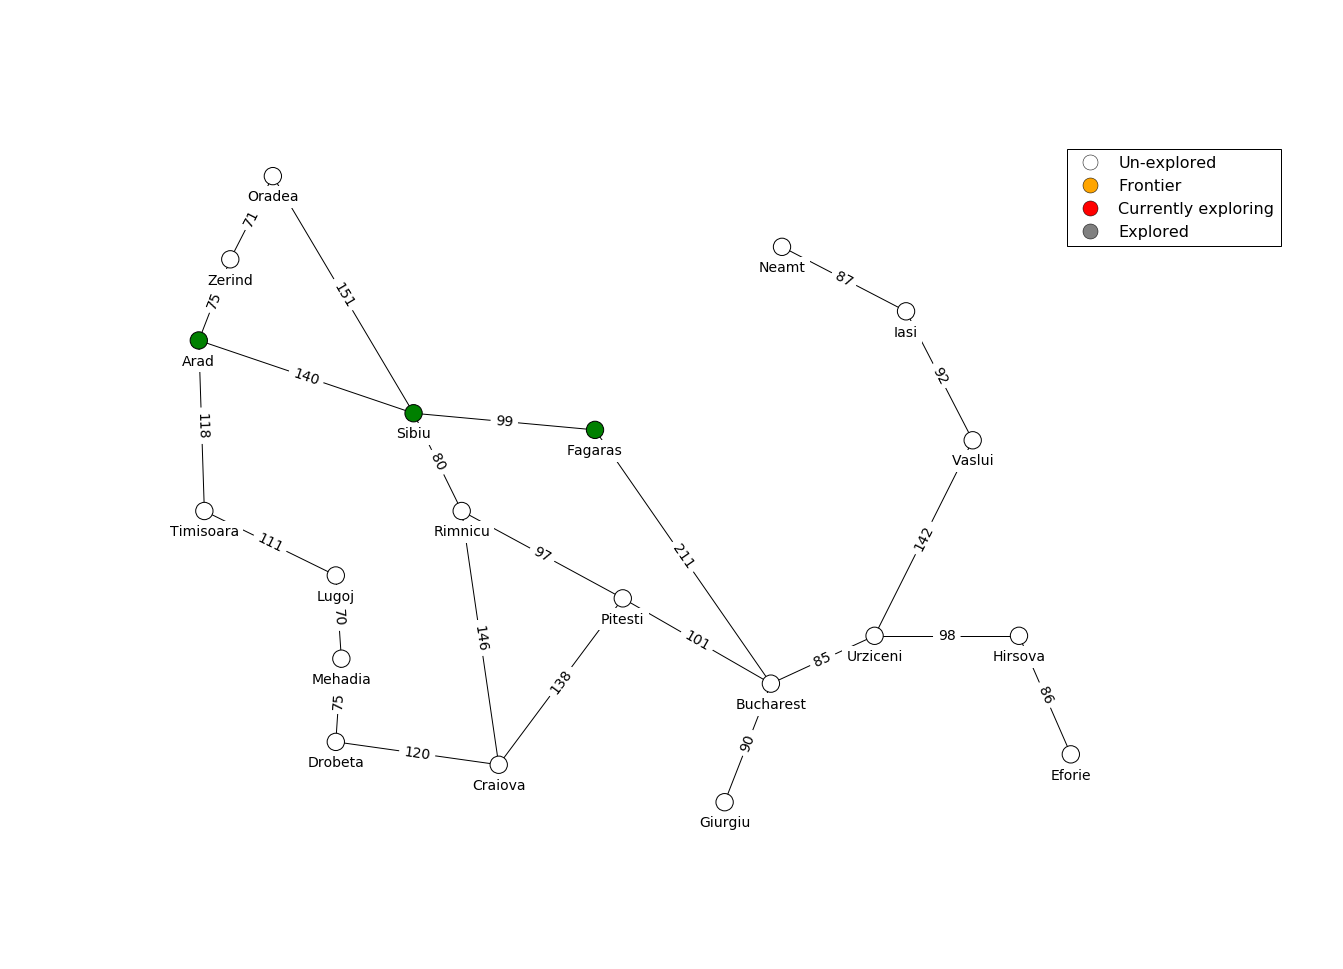

In [35]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Fagaras', romania_map)
display_visual(user_input = False, algorithm = breadth_first_tree_search, problem = romania_problem)

### A* Search

In [36]:
def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue(min, f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search(problem, lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

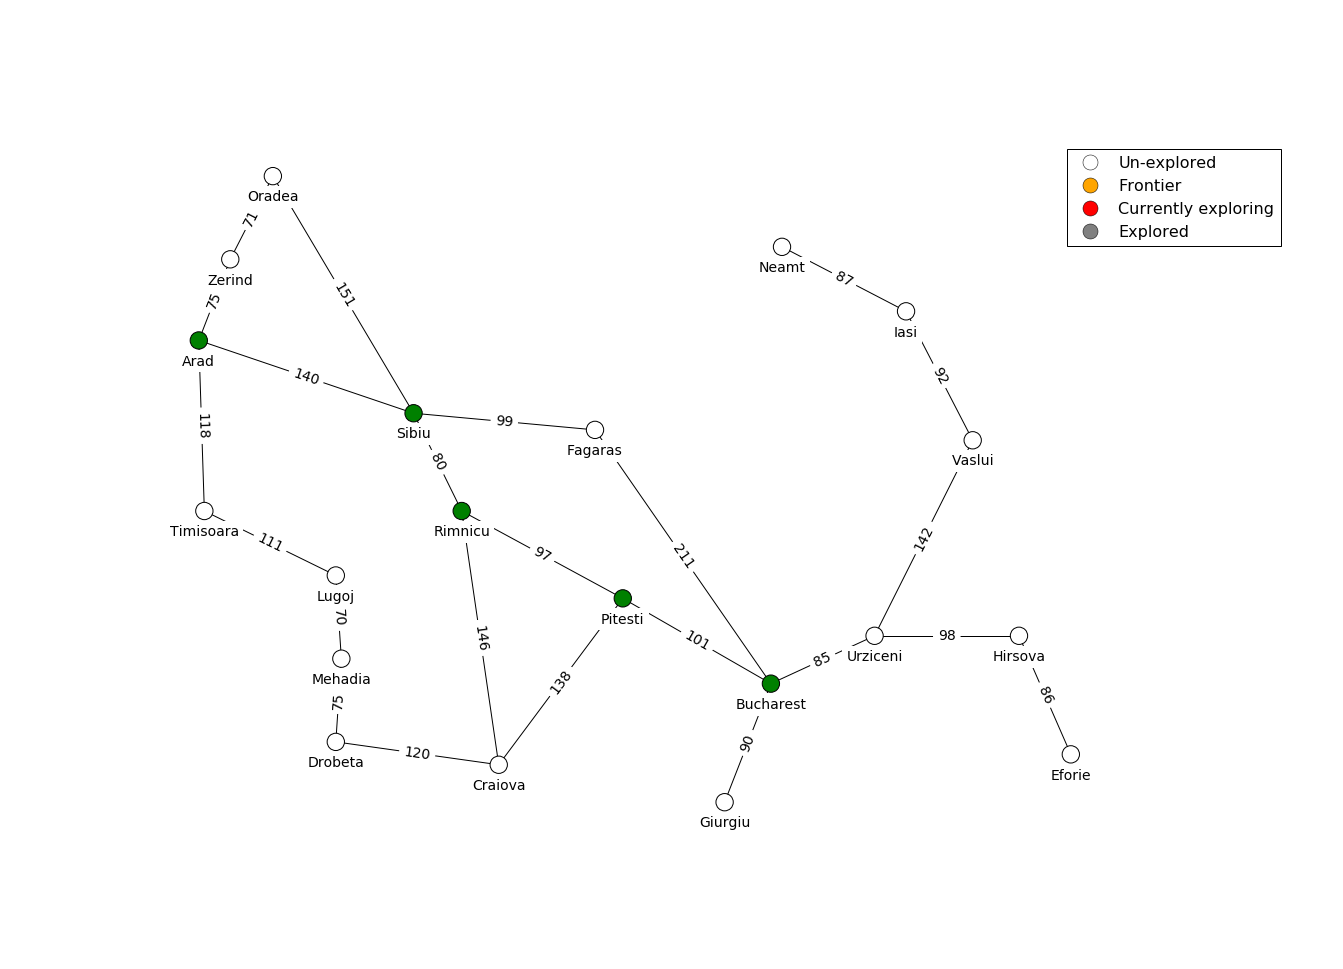

In [37]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(user_input = False, algorithm = astar_search, problem = romania_problem)

## Build a Graph by Voronoi Diagram

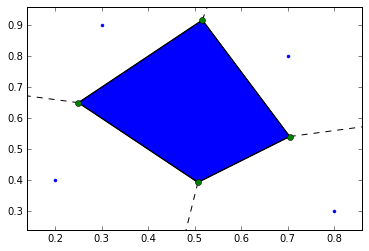

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# make up data points
points = np.array([[ 0.5, 0.7], [ 0.2, 0.4], [0.8, 0.3], [0.7, 0.8], [0.3, 0.9]])

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
voronoi_plot_2d(vor)

# colorize
for region in vor.regions:
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon))

plt.show()


In [39]:
print vor.vertices
print vor.ridge_vertices

[[ 0.50714286  0.39285714]
 [ 0.25        0.65      ]
 [ 0.70454545  0.54090909]
 [ 0.51666667  0.91666667]]
[[-1, 0], [-1, 1], [0, 1], [-1, 2], [2, 3], [-1, 3], [0, 2], [1, 3]]


## Duckie Detector + Avoidance

See detail in src/mdoap/src/static_object_detector_node.py

You may need to change the high/low color thresholds

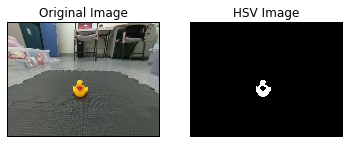

In [40]:
CONE = [np.array(x, np.uint8) for x in [[0,80,80], [22, 255,255]] ]
DUCK = [np.array(x, np.uint8) for x in [[15,100,150], [35, 255, 255]] ]

img = cv2.imread('01-tutorial/duckie_1.jpg')
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
frame_threshed = cv2.inRange(hsv_img, DUCK[0], DUCK[1])
ret,thresh = cv2.threshold(frame_threshed,15,255,0)
    
dst1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(dst1, cmap = 'brg')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(frame_threshed, cmap = 'gray')
plt.title('HSV Image'), plt.xticks([]), plt.yticks([])

plt.show()

### function to get filtered contours

In [41]:
def get_filtered_contours(img, contour_type):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    if contour_type == "CONE":
        frame_threshed = cv2.inRange(hsv_img, CONE[0], CONE[1])
        ret,thresh = cv2.threshold(frame_threshed,22,255,0)
    elif contour_type == "DUCK_COLOR":
        frame_threshed = cv2.inRange(hsv_img, DUCK[0], DUCK[1])
        ret,thresh = cv2.threshold(frame_threshed,25,255,0)
    elif contour_type == "DUCK_CANNY":
        frame_threshed = cv2.inRange(hsv_img, DUCK[0], DUCK[1])
        frame_threshed = cv2.adaptiveThreshold(frame_threshed,255,\
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,5,2)
        thresh = cv2.Canny(frame_threshed, 100,200)
    else:
        return
    
    filtered_contours = []

    contours, hierarchy = cv2.findContours(\
            thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    contour_area = [ (cv2.contourArea(c), (c) ) for c in contours]
    contour_area = sorted(contour_area,reverse=True, key=lambda x: x[0])

    height,width = img.shape[:2]
    for (area,(cnt)) in contour_area:
    # plot box around contour
        x,y,w,h = cv2.boundingRect(cnt)
        box = (x,y,w,h)
        d =  0.5*(x-width/2)**2 + (y-height)**2
        if not(h>15 and w >10 and h<200 and w<200 and d < 120000):
            continue
        if contour_type == "DUCK_CANNY":
            continue
        if contour_type =="DUCK_COLOR": # extra filtering to remove lines
            if not(h>25 and w>25):
                continue
            if d>90000:
                if not(h>35 and w>35):
                    continue
            if cv2.contourArea(cnt)==0:
                continue
            val = cv2.arcLength(cnt,True)**2/ cv2.contourArea(cnt)
            if val > 35: continue
            rect = cv2.minAreaRect(cnt)
            ctr, sides, deg = rect
            val  = 0.5*cv2.arcLength(cnt,True) / (w**2+h**2)**0.5
            if val < 1.12: continue
            #if area > 1000: continue

        mask = np.zeros(thresh.shape,np.uint8)
        cv2.drawContours(mask,[cnt],0,255,-1)
        mean_val = cv2.mean(img,mask = mask)
        aspect_ratio = float(w)/h
        filtered_contours.append( (cnt, box, d, aspect_ratio, mean_val) )
    
    return filtered_contours


### Let's detect duckie!

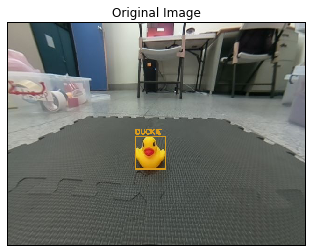

In [42]:
img = cv2.imread('01-tutorial/duckie_1.jpg')

duck_contours = get_filtered_contours(img, "DUCK_COLOR")

for (cnt, box, ds, aspect_ratio, mean_color)  in duck_contours:
    # plot box around contour
    x,y,w,h = box
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, "DUCKIE", (x,y-5), font, 0.5, mean_color, 2)
    cv2.rectangle(img,(x,y),(x+w,y+h), mean_color,2)

dst1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.subplot(111),plt.imshow(dst1, cmap = 'brg')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.show()